# Kaggle Icecore challenge

Outline:

- minor exploratory stuff (class numbers, na's with incidence angle, etc)

- Get baseline up with a vgg or inception arch on each image, and then for  final classification, pick whichever has a higher softmax output

- try image concatention like I did at aerospace, with no fine tuning

- try with fine tuning (somehow make it 3?)

- try ensembling different models (like vgg, inception, resnet)

- Then, try double vgg or inception like structure, concatenating on the    dense layers, with no fine tuing

- then with fine tuning

- try some including and excluding adding the incidence angle at the dense layers or end 

- Also, be careful with augmentation and the incidence angles, it may cause them to mess up, so it could be better to just leave incidence angles out if it allows us to do more aug



- **** Also, want to try to predict the missing incidence angles from the 
 rest of the ones we have, otherwise would have to throw out 133 images

- **** Also, need to examine the normalization, and potentially converting from decible values to something else, and then normalizing

total data points in testing:  8424
total data points in training:  1604
number of non missing inc_angles:  1471
number of missing inc_angles:  133
percent missing inc_angles:  0.09041468388851122


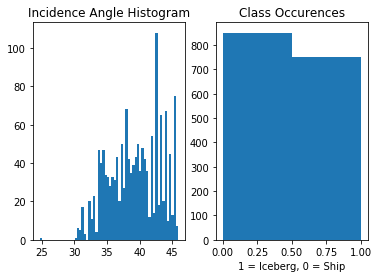

In [10]:
# exploratory stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


training_path = "../Test_data/train.json"
testing_path = "../Test_data/test.json"

train_data = pd.read_json(training_path)
test_data = pd.read_json(testing_path)

# get list of angles/classes, len train data
is_icebergs = [x for x in train_data["is_iceberg"]]
inc_angles = [y for y in train_data["inc_angle"] if isinstance(y, float)]
inc_nas = [y for y in train_data["inc_angle"] if isinstance(y, str)]

print("total data points in testing: ", len(test_data))
print("total data points in training: ", len(train_data))
print("number of non missing inc_angles: ", len(inc_angles))
print("number of missing inc_angles: ", len(inc_nas))
print("percent missing inc_angles: ", float(len(inc_nas))/float(len(inc_angles)))

plt.subplot(1, 2, 1)
plt.hist(inc_angles, bins = 60)
plt.title('Incidence Angle Histogram')

plt.subplot(1, 2, 2)
plt.hist(is_icebergs, bins = 2)
plt.title('Class Occurences')
plt.xlabel('1 = Iceberg, 0 = Ship')

plt.show()

# Notes

- The classes seem to be pretty evenly balanced, maybe about 100 less icebergs, could fix that

- the incidence angles seem a little right tailed, with a lot of them coming from exactly the same angles, interesting

band_1
DescribeResult(nobs=56407500, minmax=(-45.680545806884766, 37.090522999999997), mean=-22.159242988927875, variance=28.424440324407545, skewness=0.8502589192712555, kurtosis=2.3675551655768574)
 
band_2
DescribeResult(nobs=56407500, minmax=(-49.083500000000001, 37.090522766113281), mean=-24.953674182125951, variance=20.669753971968337, skewness=1.30140098134072, kurtosis=4.262312862918784)


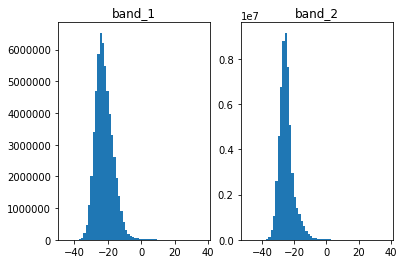

In [12]:
# need to get our data all sorted first, as well as normalize
# examining the possible values these scatterback radar's can make
# they are floats, with units in dB's

from scipy import stats

band1s = []
for i in train_data["band_1"]:
    for j in i:
        band1s.append(j)
        
for w in test_data["band_1"]:
    for z in w:
        band1s.append(z)
        
band2s = []
for r in train_data["band_2"]:
    for k in r:
        band2s.append(k)
        
for l in test_data["band_2"]:
    for s in l:
        band2s.append(s)

print("band_1")
print(stats.describe(band1s))
print(" ")
print("band_2")
print(stats.describe(band2s))
        
plt.subplot(1, 2, 1)
plt.hist(band1s, bins = 60)
plt.title('band_1')

plt.subplot(1, 2, 2)
plt.hist(band2s, bins = 60)
plt.title('band_2')

plt.show()

# Notes

- the decible values seem to be almost exactly normally distributed for band_1, band_2 may have a little right tailed

- band_1 min = -45, max = 37, 2 stds = 10
- band_2 min = -49, max = 37, 2 stds = 8.5


Normalizing decibal values can be weird, might want to look at converting them first, and them normalizing. For now, going to get a baseline without any normalization or conversion first

In [ ]:
## baseline modeling (doing it without normalization, or regularization)


In [ ]:
## Useful code snippets

# turn the flattened 'image' into 75 x 75
np.array(band).astype(np.float32).reshape(75, 75)

# concat them all together (should try more than just averging the two)
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis],
                X_band_2[:, :, :, np.newaxis], 
                          ((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]],
                         axis=-1)